# Gradient Descent with Early Stopping
The following notebook covers the gradient descent algorithm and Principal Component Analysis. It was inspired by a coursework project.

In [56]:
import numpy as np
import matplotlib.pyplot as plt

## Background Knowledge

### Probabilistic multiclass classification
Consider a classification problem with $K \in \N$ classes. For any domain point $\hat{x} \in \R^n$, we want to output not just the class itself, but probabilities that $\hat{x}$ belongs to each of the classes. Thus, our prediction rule is a vector function,

$$
\begin{aligned}
    (1) \quad h_{\Theta}(\mathbf{\hat{x}}) &= [h_{\Theta_0}(\mathbf{\hat{x}}) \cdots h_{\Theta_{K-1}}(\mathbf{\hat{x}})]: \mathbb{R}^{1 \times n} \rightarrow \mathbb{R}^{1 \times K}, \text{ where } h_{\Theta_k}: \mathbb{R}^{1 \times n} \rightarrow \mathbb{R}, \\
    (2) \quad h_{\Theta_k}(\mathbf{\hat{x}}) &\geq 0 \text{ and } \sum_{k=0}^{K-1} h_{\Theta_k}(\mathbf{\hat{x}}) = 1 \quad \forall \mathbf{\hat{x}} \in \mathbb{R}^{1 \times n}, \text{and}\\
    (3) \quad \Theta &= [\Theta_0 \cdots \Theta_{K-1}] \in \mathbb{R}^{(n+1) \times K}, \text{ where } \Theta_k \in \mathbb{R}^{(n+1) \times 1}, \quad k = 0, \ldots, K-1. \\
\end{aligned}
$$

Equation (2) ensures that $\bold{h}_Θ(\hat{x})$ is indeed a vector of probabilities (which should be nonnegative and sum up to 1), and Equation (3) defines the parameter $\theta$ as a $(n + 1) × K$ matrix to introduce the bias in the first row. 


Specifically, we take a composition of the homogenised affine function and the softmax function to ensure Equation (2) for any $\theta \in \R^{(n+1)×K}$:

$$
\begin{aligned}
    (4) \quad h_{\Theta_k}(\mathbf{\hat{x}}) = \frac{\exp(\langle \mathbf{x}, \Theta_k \rangle)}{\sum_{k'=0}^{K-1} \exp(\langle \mathbf{x}, \Theta_{k'} \rangle)}, & \quad k = 0, \ldots, K-1, \text{ where } \mathbf{x} = \begin{bmatrix} 1 \\ \mathbf{\hat{x}} \end{bmatrix} \in \mathbb{R}^{1 \times (n+1)}. \\
\end{aligned}
$$

Note that the inner product $\langle \bold{x}, \bold{\theta} \rangle$ is independent of row or column orientation of the vectors $\bold{x}$ and $\bold{\theta}$, but the chosen orientations are more convenient in Python.

A given dataset is also labelled with vector-valued labels: $\bold{D} = (\bold{\hat{X}} , \bold{Y})$, where
$$
\begin{aligned}   
    \mathbf{\hat{X}} &= \begin{bmatrix} \mathbf{x}_0 \\ \vdots \\ \mathbf{x}_{m-1} \end{bmatrix}, \quad \mathbf{Y} = \begin{bmatrix} \mathbf{y}_0 \\ \vdots \\ \mathbf{y}_{m-1} \end{bmatrix}, \text{ and } \mathbf{y}_i = [0 \cdots 1 \cdots 0] \in \mathbb{R}^{1 \times K}.
\end{aligned}
$$

for i = 0, . . . , m − 1, where the 1 appears in the position corresponding to the class of $\hat{\bold{x}_i}$. In other terms, in the given data we assume that each domain point is labelled with a unique class with 100% probability.

First let us define our softmax feature function:

In [57]:
def softmax(W):
    '''Input: an M x K np array W and 
        Output: an M x K np array P with the softmax function applied'''
    P = np.exp(W)/np.sum(np.exp(W), axis=1, keepdims=True)
    return P

Hence our prediction rule is given by the function `h()`, where `extend_X()` adds the intercept/bias term to the dataset X.

In [58]:
def extend_X(Xh):
    X = np.ones((Xh.size//Xh.shape[-1], Xh.shape[-1]+1))
    X[:, 1:] = Xh
    return X

def h(Xh, Theta):
    X = extend_X(Xh)
    return softmax(np.dot(X, Theta))


### Calculating the loss function
Since both $\bold{h}_Θ(\hat{x})$ and $\bold{y}$ are probability distributions, a suitable loss between them is the cross-entropy:

$$
\ell_{\hat{x}, y}(\Theta) = \ell(h_{\Theta}(\hat{x}), y) = - \sum_{k=0}^{K-1} y_k \log h_{\Theta_k}(\hat{x}).
$$

This gives the standard empirical risk of the entire dataset:

$$
L_D(\Theta) = -\frac{1}{m} \sum_{i=0}^{m-1} \sum_{k=0}^{K-1} y_{i,k} \log h_{\Theta_k}(\hat{x}_i).
$$

This is given by the function, `loss()`

In [59]:
def loss(Xh, Theta, Y):
    ''' Input: numpy arrays Xh (m x n), Theta ((n+1) x k), Y (m x K)
        Output: Value fo the empirical risk '''
    m = len(Y)
    L = -1/m * np.sum(Y*np.log(h(Xh, Theta)))
    return L

### Calculation of the loss gradient
Firstly we compute
$$
\log h_{\Theta_k}(\hat{x}) = \langle x, \Theta_k \rangle - \log \left[ \sum_{k'=0}^{K-1} \exp(\langle x, \Theta_{k'} \rangle) \right]
$$

The partial derivative in the parameter component $\theta_{j_* , k_*}$ reads

$$
\frac{\partial \log h_{\Theta_k}(\hat{x})}{\partial \Theta_{j_*, k_*}} = x_{j_*} \delta_{k, k_*} - \frac{1}{\sum_{k'=0}^{K-1} \exp(\langle x, \Theta_{k'} \rangle)} \left[ \sum_{k'=0}^{K-1} \exp(\langle x, \Theta_{k'} \rangle) x_{j_*} \delta_{k', k_*} \right]
$$
$$
= x_{j_*} \delta_{k, k_*} - \exp(\langle x, \Theta_{k_*} \rangle) \frac{x_{j_*}}{\sum_{k'=0}^{K-1} \exp(\langle x, \Theta_{k'} \rangle)}
$$
$$
= x_{j_*} (\delta_{k, k_*} - h_{\Theta_{k_*}}(\hat{x})),
$$

where 
$$
\delta_{k,k'} = 
\begin{cases} 
1, & \text{if } k = k', \\
0, & \text{otherwise}.
\end{cases}
$$

Now the partial derivative of the total empirical risk becomes
$$
(\nabla L_D(\Theta))_{j_*, k_*} = \frac{\partial L_D(\Theta)}{\partial \Theta_{j_*, k_*}} = \frac{1}{m} \sum_{i=0}^{m-1} \left[x_{i, j_*} \left( \left(\sum_{k=0}^{K-1} y_{i, k} \right) h_{\Theta_{k_*}}(\hat{x}_i) - y_{i, k_*} \right)\right],
$$
 
for $j_* = 0, . . . , n $  and  $k_* = 0, . . . , K − 1$. Note that since $\bold{y}_i$ is a vector of probabilities, $\sum_{k=0}^{K-1} y_{i, k} = 1$ can be ommited.

In [60]:
def grad_loss(Xh, Theta, Y):
    ''' Input: numpy arrays Xh (m x n), Theta ((n+1) x k), Y (m x K)
        Output: numpy array G ((n+1) x k) with elements of the gradient'''
    m = len(Y)
    X = extend_X(Xh)
    G = 1/m * X.T @ (h(Xh, Theta) - Y)
    return G

### Data Splitting
Data splitting is a random a priori partitioning of the given dataset $\bold{D}$ into a training dataset $\bold{D}_{train}$ and a test dataset $\bold{D}_{test}$ such that $\bold{D} = \bold{D}_{train} \cup \bold{D}_{test}$, where $\bold{D}_{train} \cap \bold{D}_{test} = \emptyset$. The reason for splitting the data is so the prediction loss can be estimated by the training data and then evaluated on new test data.



In [61]:
def data_split(X,Y, Mtest=50):
    ''' Input: np arrays X (MxN), Y (MxK), and int Mtest=50
        Output: Data split into train and test '''
    I = np.arange(len(X)) # Initialising an array for the index sequence
    np.random.shuffle(I) # Shuffling index sequence
    Itest, Itrain = I[:Mtest], I[Mtest:]
    
    Xtrain, Ytrain = X[Itrain], Y[Itrain]
    Xtest, Ytest = X[Itest], Y[Itest]

    return Xtrain, Ytrain, Xtest, Ytest

### Gradient Descent (GD) with data splitting and early stopping
Since the minimal cross-entropy loss may not be exactly zero (especially for non-separable data), we
cannot stop GD by thresholding the loss itself or its gradient. Instead, we split the entire data
into training and test sets, and employ the early stopping in GD, as shown in the following pseudocode:

Algorithm 1: Gradient Descent (GD) method with early stopping
Require: Training dataset $D_{\text{train}} = (X_{\text{train}}, Y_{\text{train}})$, test dataset $D_{\text{test}} = (X_{\text{test}}, Y_{\text{test}})$, initial guess $\Theta_0$, constant learning rate $t \geq 0$, iteration gap $p \in \mathbb{N}$, loss reduction threshold $q > 0$, maximal number of iterations $S \in \mathbb{N}$

1. for $s = 0, 1, \ldots, S-1$ do
2. $\quad$ if $s \geq p$ and $L_{D_{\text{test}}}(\Theta_s) > q \cdot L_{D_{\text{test}}}(\Theta_{s-p})$ then
3. $\quad \quad$ break
4. $\quad$ end if
5. $\quad$ Compute $G = \nabla L_{D_{\text{train}}}(\Theta_s) \in \mathbb{R}^{(n+1) \times K}$
6. $\quad$ Update the iterate $\Theta_{s+1} = \Theta_s - tG$.
7. end for
8. return $\Theta_s$, where $s = \arg\min_{s=0, \ldots, S} L_{D_{\text{test}}}(\Theta_s)$.

In [62]:
def gd(Xtrain, Ytrain, Xtest, Ytest, Theta0, t=1, p=100, q=0.99, S=1000):
    ''' Input: Split up Data set, initial theta, learning rate t, iteration gap p, 
                loss reduction threshold q, max number of iterations S.
        Output: Optimal theta, Iteration number of optimal theta, and test loss for optimal theta'''
    Theta = Theta0
    L_Dtest = []
    Theta_sstar = Theta0
    min_loss = loss(Xtest, Theta0, Ytest)

    for s in range(S):
        L_Dtest.append(loss(Xtest, Theta, Ytest))
        
        if L_Dtest[-1] < min_loss:
            min_loss =  L_Dtest[-1]
            Theta_sstar = Theta

        if s >= p and L_Dtest[s] > q * L_Dtest[s-p]:
            break
        
        G = grad_loss(Xtrain, Theta, Ytrain)
        Theta -= t*G

    return Theta_sstar, np.argmin(L_Dtest), L_Dtest

### ARGMIN NOT UNIQUE PLS FIX

### Testing

#### Testing our functions on basic cases

In [63]:
def test_h1():
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    assert np.abs(h(Xh, Theta) - 1)<1e-7, "test_h1 detected a wrong h value"

def test_loss1():
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    Y = np.array([[1]])
    assert np.abs(loss(Xh, Theta, Y))<1e-7, "test_loss1 detected a wrong loss value"

def test_grad1():
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    Y = np.array([[1]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y))<1e-7, "test_grad1 detected a wrong gradient value"

def test_h2():
    Xh = np.array([[-1]])
    Theta = np.array([[1,0,0], [1,0,0]])
    assert np.linalg.norm(h(Xh, Theta) - np.ones((1,3))/3)<1e-7, "test_h2 detected a wrong h value"

def test_loss2():
    Xh = np.array([[-1]])
    Theta = np.array([[1,0,0], [1,0,0]])
    Y = np.array([[0.5,0,0.5]])
    assert np.abs(loss(Xh, Theta, Y) - np.log(3))<1e-7, "test_loss2 detected a wrong loss value"

def test_grad2():
    Xh = np.array([[-1]])
    Theta = np.array([[1,0,0], [1,0,0]])
    Y = np.array([[0.5,0,0.5]])
    G_exact = np.array([[-1/6,1/3,-1/6], [1/6,-1/3,1/6]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y) - G_exact)<1e-7, "test_grad2 detected a wrong gradient value"

def test_h3():
    Xh = np.array([[1,0], [0,1]])
    Theta = np.array([[1,0], [0,1], [0,1]])
    assert np.linalg.norm(h(Xh, Theta) - np.ones((2,2))/2)<1e-7, "test_h3 detected a wrong h value"

def test_loss3():
    Xh = np.array([[1,0], [0,1]])
    Theta = np.array([[1,0], [0,1], [0,1]])
    Y = np.array([[0,1], [0.25,0.75]])
    assert np.abs(loss(Xh, Theta, Y) + np.log(0.5))<1e-7, "test_loss3 detected a wrong loss value"

def test_grad3():
    Xh = np.array([[1,0], [0,1]])
    Theta = np.array([[1,0], [0,1], [0,1]])
    Y = np.array([[0,1], [0.25,0.75]])
    G_exact = np.array([[3/8,-3/8], [1/4,-1/4], [1/8,-1/8]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y) - G_exact)<1e-7, "test_grad3 detected a wrong gradient value"

test_h1()
test_h2()
test_h3()

test_loss1()
test_loss2()
test_loss3()

test_grad1()
test_grad2()
test_grad3()



### Testing GD on synthetic data

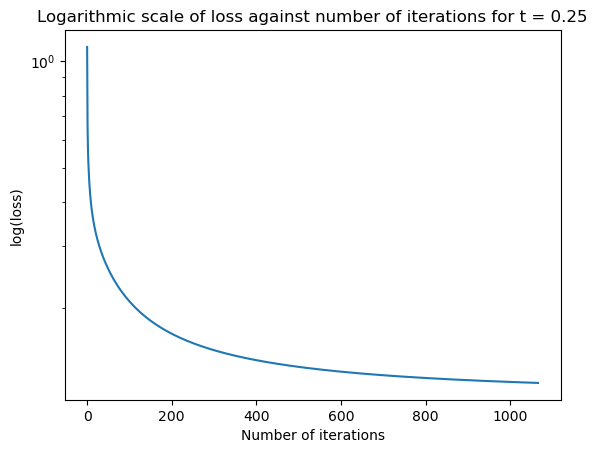

The iteration stops at s = 1067
The iteration number s* of the smallest test loss is: 1066
The value of Theta_s* is: array([[ 2.79395129, -0.03183532, -2.76211596],
       [ 0.87723028, -2.82731973,  1.95008944],
       [ 1.25883804,  0.03325706, -1.2920951 ]])


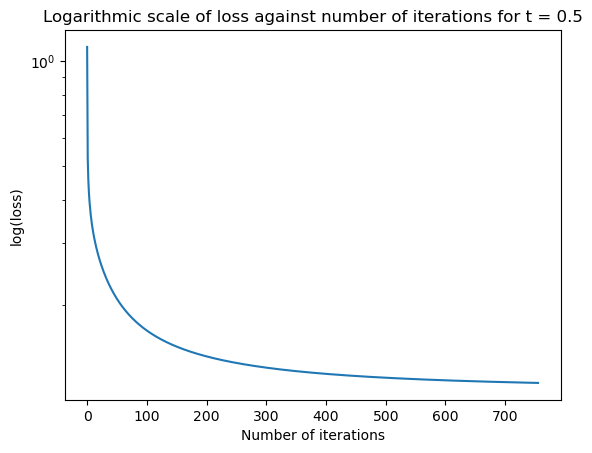

The iteration stops at s = 756
The iteration number s* of the smallest test loss is: 755
The value of Theta_s* is: array([[ 2.96176249,  0.05103495, -3.01279744],
       [ 0.91702903, -3.01509274,  2.09806371],
       [ 1.31457936,  0.05150091, -1.36608027]])


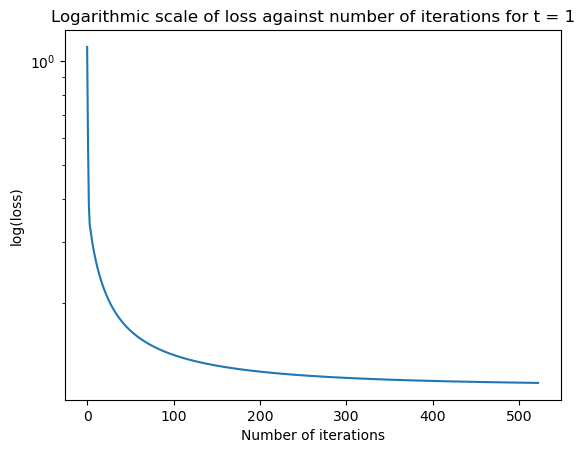

The iteration stops at s = 523
The iteration number s* of the smallest test loss is: 522
The value of Theta_s* is: array([[ 3.10006075,  0.12337792, -3.22343867],
       [ 0.94825171, -3.16623402,  2.21798231],
       [ 1.36382593,  0.06510331, -1.42892924]])


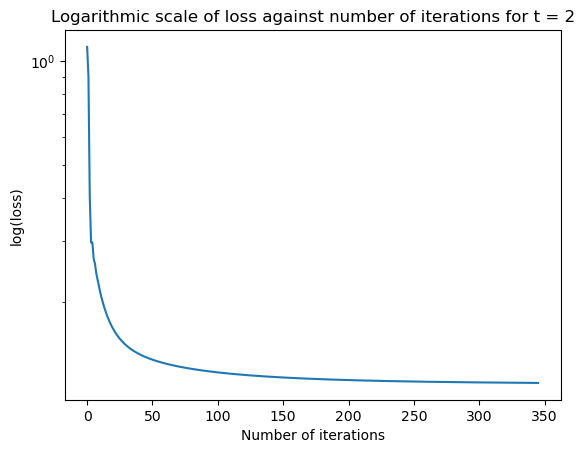

The iteration stops at s = 346
The iteration number s* of the smallest test loss is: 345
The value of Theta_s* is: array([[ 3.20827177,  0.16154282, -3.36981459],
       [ 0.98317508, -3.30108949,  2.31791442],
       [ 1.40589543,  0.06306554, -1.46896097]])


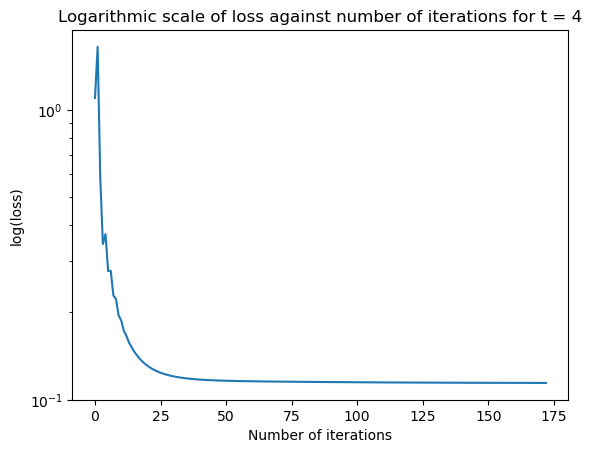

The iteration stops at s = 173
The iteration number s* of the smallest test loss is: 172
The value of Theta_s* is: array([[ 3.34751321, -0.05897231, -3.2885409 ],
       [ 1.19492326, -3.75096356,  2.55604031],
       [ 1.48989718, -0.10481605, -1.38508113]])


In [64]:
def synthetic_data(m=300):
    Xh = np.vstack([np.random.randn(m//3,2) + np.array([1,0]),
                    np.random.randn(m//3,2) + np.array([-3,-1]), 
                    np.random.randn(m//3,2) + np.array([3,-3])])
    Y = np.vstack([np.ones((m//3,1)) @ np.array([[1,0,0]]),
                   np.ones((m//3,1)) @ np.array([[0,1,0]]),
                   np.ones((m//3,1)) @ np.array([[0,0,1]])])
    return Xh, Y


# Creating Xh and Y using the synthetic data function
Xh, Y = synthetic_data()

# Splitting the data Xh, Y into the training set and test set
Xtrain, Ytrain, Xtest, Ytest = data_split(Xh,Y)

for t in [1/4, 1/2, 1, 2, 4]:
    Theta_sstar, s_star, L_Dtest = gd(Xtrain, Ytrain, Xtest, Ytest, Theta0=np.zeros((3,3)), t=t, S=10**4)

    plt.plot(np.arange(len(L_Dtest)), L_Dtest)
    plt.yscale('log')
    plt.xlabel("Number of iterations")
    plt.ylabel("log(loss)")
    plt.title(f"Logarithmic scale of loss against number of iterations for t = {t}")
    plt.show()
    print(f"The iteration stops at s = {len(L_Dtest)}")
    print(f"The iteration number s* of the smallest test loss is: {s_star}")
    print(f"The value of Theta_s* is: {repr(Theta_sstar)}")

After re-running multiple times, the value of t which consistently produces a plot for which it
looks like the loss is monotonically decreasing is t=1. For t=2 and t=4, there are runs where
the loss starts to oscillate in its descent.

The best iteration number s∗ is regularly 1 less than the last iteration number s which is to be
expected for a monotonically decreasing function due to the break condition occurring when
it stops being monotonically decreasing.

For t=1, The smallest iterations number s I have observed is 181, the largest iteration
number is 1550. This is a substantial variation and likely a result of the randomised synthetic
data. With the given parameters, specifically p=100, s cannot be less than 100 because the
break condition that s>=p is not satisfied for s < p.

The smallest test loss over all t and runs I have observed is 0.04467 for t=4. It is convenient
to use the stopping criterion to prevent overfitting and the stopping criterion as in Algorithm 1
is convenient because it helps to avoid local minima in the test loss as the test loss is not
always monotonically decreasing on a small scale but is on a larger scale. Early stopping also helps to avoid thresholding non-zero loss which may never converge if the expected risk is greater than the threshold.

In order to plot the data so that we can see the accuracy of the multi-class classification algorithm, we define the following function:

In [65]:
def plot_2D_data(Xh, Y, Theta=0):
    X1,X2 = np.meshgrid(np.linspace(-8,8,99), np.linspace(-8,8,99))
    Xgrid = np.vstack([X1.ravel(), X2.ravel()]).T
    try:
        Ypred = h(Xgrid, Theta)
    except:
        Ypred = 0.5*np.ones((Xgrid.shape[0], Y.shape[1]))
    plt.figure(figsize=(10,10))
    for k in range(Y.shape[1]):
        plt.subplot(2, int(np.ceil(Y.shape[1]/2)), k+1)
        plt.contourf(X1, X2, Ypred[:,k].reshape(X1.shape), cmap='gray')
        for j in range(Y.shape[1]):
            plt.scatter(Xh[np.argmax(Y, axis=1)==j, 0], Xh[np.argmax(Y, axis=1)==j, 1], label=f"class {j}")
        plt.title("$h_{θ_{"+str(k)+"}}$")
        plt.xlabel("$\hat x_1$")
        plt.ylabel("$\hat x_2$")
        plt.legend()
    plt.show()

Based on the results of our previous plots, we choose the constant learning rate t to be 1 and will recompute the optimal theta.

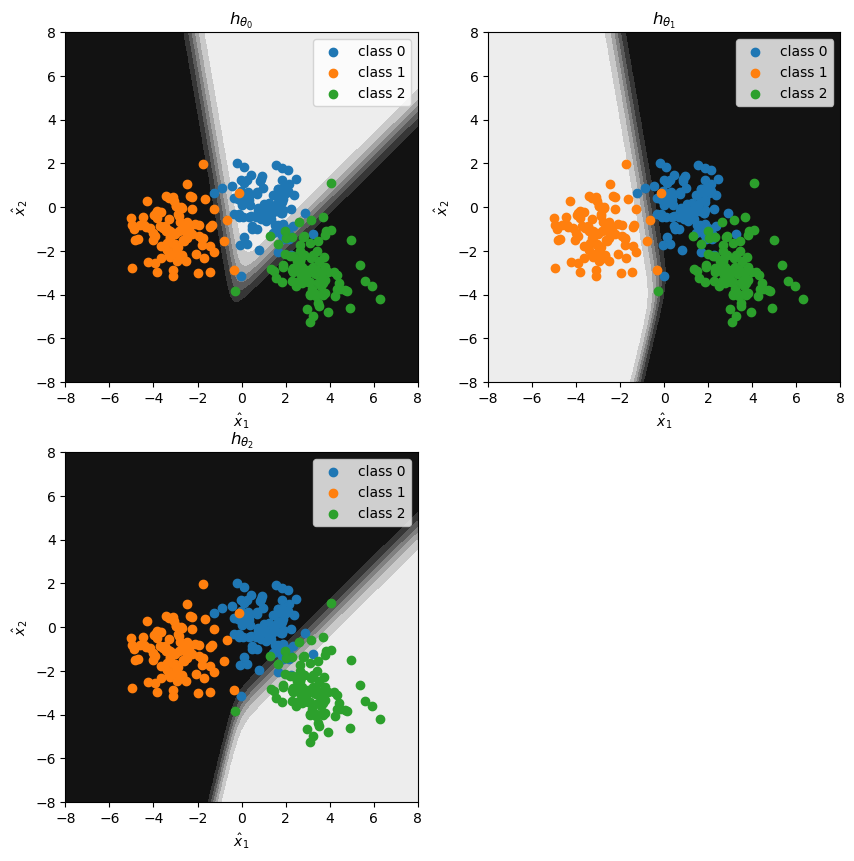

The average test loss for this Theta_s* is 0.0392271491763038
Accuracy of the multi-class classification algorithm: 0.98


In [66]:
Xh, Y = synthetic_data()
# Splitting the data Xh, Y into the training set and test set
Xtrain, Ytrain, Xtest, Ytest = data_split(Xh,Y)
Theta_sstar, s_star, L_Dtest = gd(Xtrain, Ytrain, Xtest, Ytest, Theta0=np.zeros((3,3)), t=1, S=10**4)

# plot the data Xh, Y and the predicted class probabilities hΘs∗(ˆx)
from sklearn.metrics import accuracy_score
plot_2D_data(Xh, Y, Theta_sstar)
print(f"The average test loss for this Theta_s* is", loss(Xtest, Theta_sstar, Ytest))
print(f"Accuracy of the multi-class classification algorithm: {accuracy_score(np.argmax(Ytest, axis=1), np.argmax(h(Xtest, Theta_sstar), axis=1))}")

Visually, from 'plot_2D_data', we can see that the classes are reasonably accurate with few
points which could be incorrectly classified. A quantitative indicator that can measure the
accuracy of multi-class classification labels is the function ‘accuracy_score()` from the
sklearn.metrics library which returns the fraction of correctly classified samples. The
accuracy of this problem ranges between around 94-98% which is very accurate.

## Principal Component Analysis (PCA) for large data

Some data have a rather large $n$, e.g. a thousand. Direct classification of such $\bold{\hat{x}}$ is slow and prone to overfitting. Instead we can first try to compress the data with PCA.

Note though that $\bold{\hat{x}}$ here is a row vector, in contrast to column vectors typically seen. So we need to transpose the vectors and solve:
$$
\arg \max_{U \in \mathbb{R}^{n \times r}, U^T U = I} \text{trace}(U^T A U), \quad \text{where } A = -\frac{1}{m} \sum_{i=0}^{m-1} \mathbf{x}_i \mathbf{x}_i^T \in \mathbb{R}^{n \times n}.
$$

Having found $U \in \R^{n \times r}$ as the $r$ eigenvectors corresponding to $r$ largest eigenvalues of A, we compute the compressed vectors also in the transposed form,
$$
\bold{\hat{z}} = \bold{\hat{x}}U, \quad \forall \bold{\hat{x}} \in \R^{1 \times n}$$

### Loading and PCA of spectromicroscopy data
The file PCA.npz contains the following variables:
- Xh: a $300 \times 1000$ matrix of possibly noisy and contaminated X-ray absorption spectra of several chromium compounds.
- Y: a $300 \times 3$ matrix of labels for these spectra
- Xhnew: a $33^2 \times 1000$ matrix of spectra taken at $33 \times 33$ pixels of an unknown specimen

In [67]:
D = np.load("PCA.npz")
Xh = D['Xh']
Y = D['Y']
Xhnew = D['Xhnew']

r = 3
A = (Xh.T @ Xh)/Xh.shape[0]
Lambda, U = np.linalg.eigh(A)

# Since eigh returns the eigenvalues in ascending order in a vector Lambda
# and the eigenvectors are in corresponding order in U, we take the last r vectors from U
U = U[:,-3:]

# Computing the compressed vectors and storing in a  300 x 3 matrix Zh
Zh = Xh @ U

# Compressing the specimen data into a 33^2 x 3 matrix Zhnew using the same matrix U
Zhnew = Xhnew @ U

### Classification of spectromicroscopy data


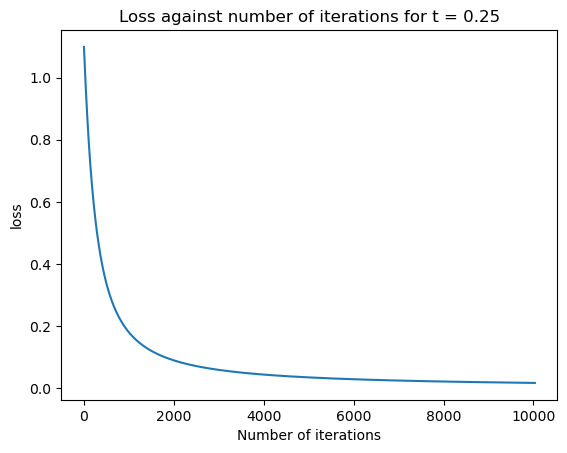

The iteration stops at s = 10033
The iteration number s* of the smallest test loss is: 10032
The value of Theta_s* is: array([[ -0.50246382,  -0.10566027,   0.6081241 ],
       [ 16.77419668, -12.94152851,  -3.83266817],
       [ -4.32985504, -11.37108459,  15.70093963],
       [  0.27522327,   0.03033422,  -0.30555749]])


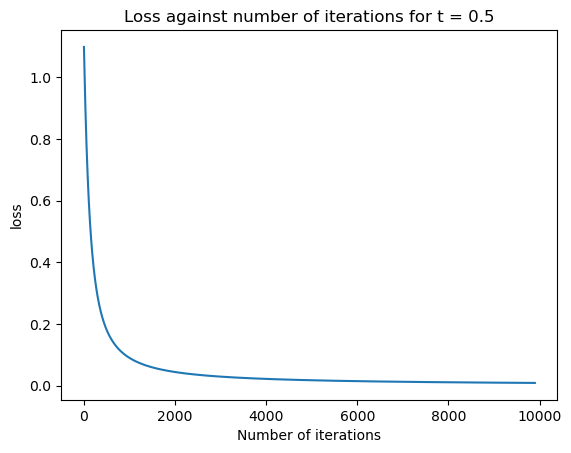

The iteration stops at s = 9899
The iteration number s* of the smallest test loss is: 9898
The value of Theta_s* is: array([[ -0.5854926 ,  -0.1084832 ,   0.6939758 ],
       [ 19.61635241, -15.29586392,  -4.3204885 ],
       [ -4.96342957, -12.94431894,  17.9077485 ],
       [  0.31643077,   0.0260009 ,  -0.34243167]])


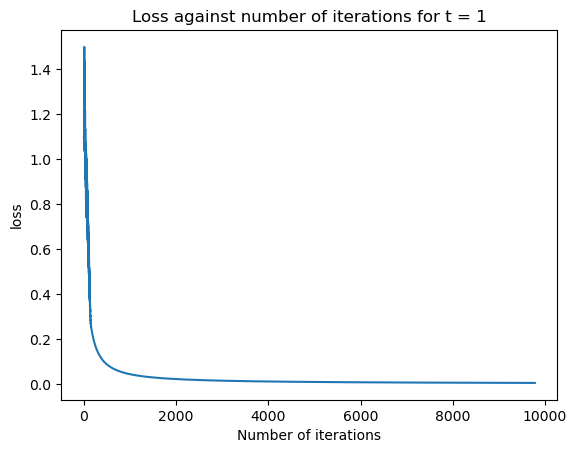

The iteration stops at s = 9779
The iteration number s* of the smallest test loss is: 9778
The value of Theta_s* is: array([[-6.69354125e-01, -1.10084271e-01,  7.79438396e-01],
       [ 2.24859785e+01, -1.77212818e+01, -4.76469668e+00],
       [-5.60716118e+00, -1.45195214e+01,  2.01266826e+01],
       [ 3.58421695e-01,  1.96154785e-02, -3.78037174e-01]])


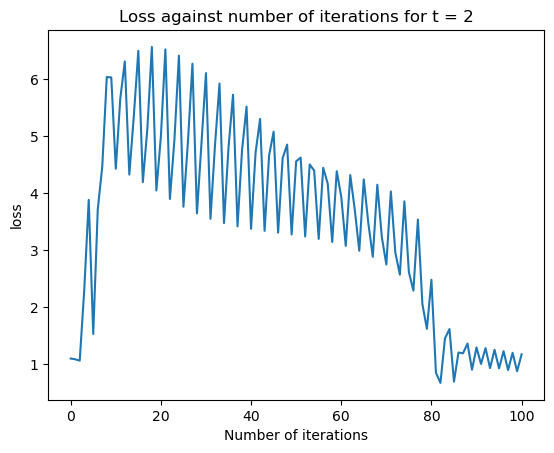

The iteration stops at s = 101
The iteration number s* of the smallest test loss is: 82
The value of Theta_s* is: array([[-0.69427831,  0.11878373,  0.57549458],
       [ 9.8365905 , -7.49832746, -2.33826304],
       [-3.36848149, -9.16381708, 12.53229857],
       [-0.85043812,  0.7975555 ,  0.05288262]])


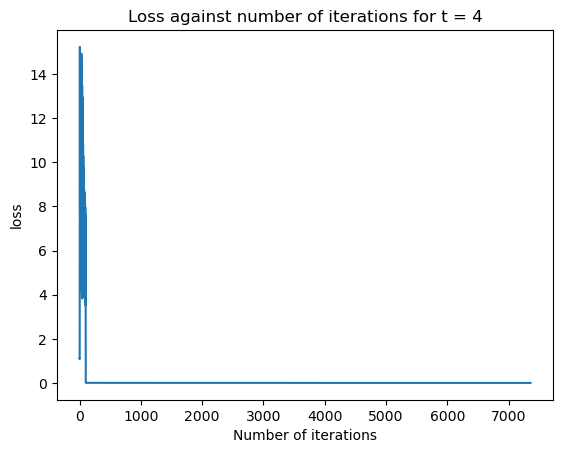

The iteration stops at s = 7357
The iteration number s* of the smallest test loss is: 7356
The value of Theta_s* is: array([[ -0.8305725 ,  -0.32615076,   1.15672326],
       [ 27.06231713, -21.32112315,  -5.74119399],
       [ -8.68282537, -22.79401409,  31.47683946],
       [  0.57591194,   0.07741302,  -0.65332496]])


In [68]:
# Data splitting
Ztrain, Ytrain, Ztest, Ytest = data_split(Zh, Y)

# Varying t
for t in [1/4, 1/2, 1, 2, 4]:
    Theta_sstar, s_star, L_Dtest = gd(Ztrain, Ytrain, Ztest, Ytest, Theta0 = np.zeros((4,3)), t=t, S=10**5)
    plt.plot(np.arange(len(L_Dtest)), L_Dtest)
    plt.xlabel("Number of iterations")
    plt.ylabel("loss")
    plt.title(f"Loss against number of iterations for t = {t}")
    plt.show()
    print(f"The iteration stops at s = {len(L_Dtest)}")
    print(f"The iteration number s* of the smallest test loss is: {s_star}")
    print(f"The value of Theta_s* is: {repr(Theta_sstar)}")

Hnew = [[9.70618947e-01 1.64707210e-02 1.29103319e-02]
 [4.12505045e-01 5.87154921e-01 3.40033663e-04]
 [4.29564657e-01 5.70099749e-01 3.35594107e-04]
 ...
 [4.28019216e-01 5.71642897e-01 3.37886492e-04]
 [4.30023230e-01 5.69627824e-01 3.48945249e-04]
 [4.35413731e-01 5.64227272e-01 3.58997288e-04]]


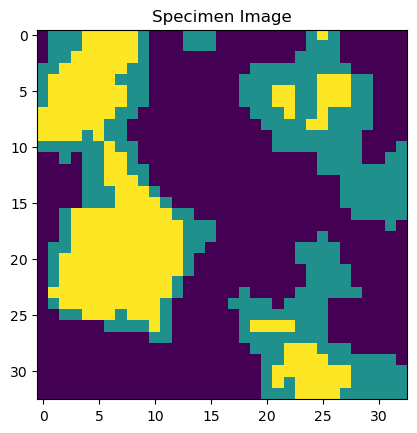

In [70]:
# One run of gd at the chosen t = 0.5, to get the corresponding value of Theta_s*
Ztrain, Ytrain, Ztest, Ytest = data_split(Zh, Y) # Randomised data splitting
Theta_sstar, s_star, L_Dtest = gd(Ztrain, Ytrain, Ztest, Ytest, Theta0 = np.zeros((4,3)), t=0.5, S=10**5)

# Calculating the matrix of predicted probabilities
Hnew = h(Zhnew, Theta_sstar)
print(f"Hnew = {Hnew}")

# Calculating the predicted class labels in the matrix K
K = np.zeros((33,33)) # initialising K 

for i1 in range(0,33):
    for i2 in range(0,33):
        i = 33*i1 + i2
        K[i1,i2] = np.argmax(Hnew[i])

plt.imshow(K)  # plot image
plt.title("Specimen Image")
plt.show()

I have chosen a maximal value of t to be 0.5 because for t = 2,4 the plots are clearly not
monotonically decreasing. From closer inspection of the plots, t=1 also appears to not be
monotonically decreasing as there are rapid oscillations on the steep part of the curve.

The specimen classification image K appears to be very reproducible returning a very similar
image each time after running it multiple times. This is to be expected as the data remains
the same (not randomised synthetic data) and the initial theta is constant. However, the data
splitting is randomised which results in occasional runs which 'misclassify' a couple of
'yellow' points as 'purple' points.

The behaviour of GD is similar to Q7 for lower learning rates (t=0.25, 0.5, 1) whereas for
high learning rates (t=2,4) it is much more unstable and overshooting the optimal value of
theta hence resulting in much greater minimum test losses. 